# PHYS20762 - Example of Monte Carlo Calculations

(c) Hywel Owen  
University of Manchester  
26th April 2020

In this notebook, I show the classic example of using Monte Carlo to calculate $\pi$. I also show how to speed up the calculation significantly by using the **Numba** Python package to created compiled Python code.

## Monte Carlo Calculation of Pi

First, we load the usual packages into Python:

In [1]:
# Uncomment the line below to be able to spin all the plots.
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

We saw in a separate notebook that the Numpy random() command generates uniformly-distributed numbers from 0 to 1. We can use pairs of these numbers to make a Monte-Carlo estimate of $\pi$. We use so-called *rejection* sampling, which is attributed in modern times to von Neumann but which was used by the Comte de Buffon in his 'Buffon's Needle' experiment.

In [35]:
# Number of Monte Carlo samples
number_of_samples = 100000
# Running tally of how many samples were inside a quarter circle of radius 1
tally = 0
# Generate samples
for i in range(number_of_samples):
    x = np.random.random()
    y = np.random.random()
    r = np.sqrt(x*x + y*y)
    if r < 1:
        # If the sample lies inside the radius r = 1 then add 1 to the tally
        tally = tally + 1
pi_estimate = 4*tally/number_of_samples
print(pi_estimate)

3.13912


If you vary the number of samples, you can see that increasing the number of samples produces estimates of pi that become progressively closer to the value of $\pi$.

It would be nice to visualise this. Let's generate 1000 samples and plot the points that lie inside $r=1$:

Estimate of pi is = 3.1512


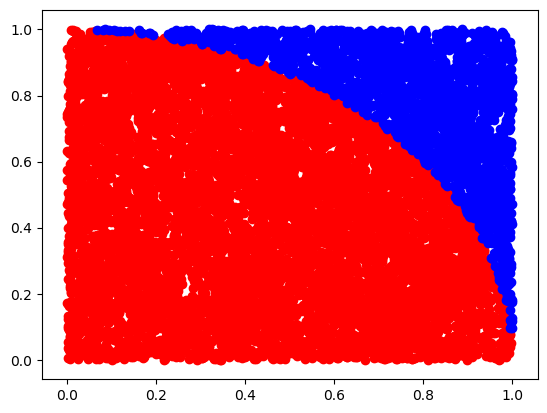

In [3]:
# Number of Monte Carlo samples
number_of_samples = 10000
# Running tally of how many samples were inside a quarter circle of radius 1
tally = 0
# List of x,y values inside the circle r = 1
x_inside = np.zeros(0)
y_inside = np.zeros(0)
x_outside = np.zeros(0)
y_outside = np.zeros(0)
# Generate samples
for i in range(number_of_samples):
    x = np.random.random()
    y = np.random.random()
    r = np.sqrt(x*x + y*y)
    if r < 1:
        # If the sample lies inside the radius r = 1 then add 1 to the tally
        tally = tally + 1
        x_inside = np.append(x_inside,x)
        y_inside = np.append(y_inside,y)
    else:
        x_outside = np.append(x_outside,x)
        y_outside = np.append(y_outside,y)
pi_estimate = 4*tally/number_of_samples
print('Estimate of pi is = {:04.4f}'.format(pi_estimate))
plt.scatter(x_inside,y_inside,color='red')
plt.scatter(x_outside,y_outside,color='blue')

You can see clearly the *accepted* points in red, and the *rejected* points in blue. The ratio (red)/(red+blue) should be $\pi/4$. Hence, we can estimate $\pi$ by calculating 4*tally/number_of_samples

Further below, we will start to use **Numba** - a Python compiler library - to speed up our code. But for now, let's use the standard Numba example to calculate $\pi$ for a given number of samples. It looks very similar to what we had above, just written a little more concisely:

In [4]:
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = np.random.random()
        y = np.random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [5]:
monte_carlo_pi(10000)

3.1384

Let's generate a set of sample numbers, and plot the estimate of $\pi$:

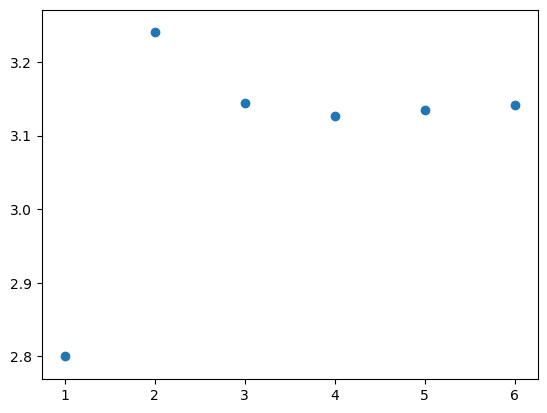

In [6]:
nsamples_set = [10,100,1000,10000,100000,1000000]
pi_estimate_set = np.zeros(0) # Initialise empty Numpy array
for i in nsamples_set:
    pi_estimate_set = np.append(pi_estimate_set,monte_carlo_pi(i))
plt.scatter(np.log10(nsamples_set),pi_estimate_set)

This method appears to work okay, and gives a better estimate each time. However, really we should run the estimates several times for each value of **nsamples**:

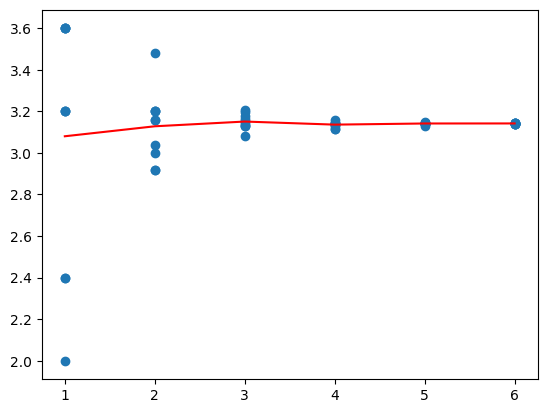

In [34]:
nsamples_set = [10,100,1000,10000,100000,1000000] # What values of nsamples to use
n_for_each_nsamples = 10 # How many times to calculate pi for each nsamples value
n_values = np.zeros(0) # Initialise empty Numpy array
pi_estimate_set = np.zeros(0) # Initialise empty Numpy array
pi_estimate_means = np.zeros(0)
for i in nsamples_set:
    this_pi_mean = 0 # Add up the j values of pi for each nsamples value
    for j in range(n_for_each_nsamples):
        n_values  = np.append(n_values,i)
        this_pi_estimate = monte_carlo_pi(i)
        pi_estimate_set = np.append(pi_estimate_set,this_pi_estimate)
        this_pi_mean = this_pi_mean + this_pi_estimate
    this_pi_mean = this_pi_mean/n_for_each_nsamples # Calculate mean value of pi for this i
    pi_estimate_means = np.append(pi_estimate_means,this_pi_mean)
plt.scatter(np.log10(n_values),pi_estimate_set) # Plot the individual pi estimates
plt.plot(np.log10(nsamples_set),pi_estimate_means,color='red') # Plot the means

## Speeding up the calculation of Pi

Is it possible to speed up this calculation, to get a more accurate estimate of $\pi$? The answer is yes - we can **compile** our Python code using the **Numba** package. First, let's find out how fast our calculation is going *without* compiling. We can do this using the line magic comman **%timeit**:

In [17]:
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = np.random.random()
        y = np.random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

%timeit monte_carlo_pi(10000)

9.49 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's not too bad - 10,0000 samples takes about 10 milliseconds. But we can do better. We use the Numba package and add a so-called **decorator** to the function definition to make the compilation happen:

In [18]:
from numba import jit

@jit(nopython=True)
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = np.random.random()
        y = np.random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

monte_carlo_pi(10000)

3.1496

The first time this amended function is called, it doesn't seem to run much faster. But this because on first execution the code is being compiled - this happens only once. After that, the compiled code is available to be run multiple times. Let's do that, and time it again:

In [24]:
%timeit monte_carlo_pi(10000)

152 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


The compiled code is running something like *60 times faster* (check that ratio on your own computer). That is a great improvement. Using this compiled code (without changing *any* of our previous Python code), we can now get our Monte Carlo estimate of $\pi$ calculated more quickly:

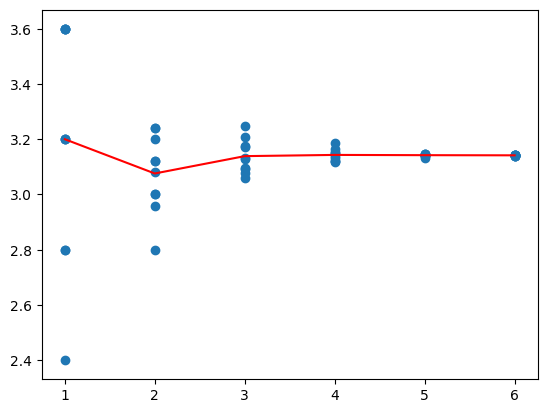

In [25]:
nsamples_set = [10,100,1000,10000,100000,1000000] # What values of nsamples to use
n_for_each_nsamples = 10 # How many times to calculate pi for each nsamples value
n_values = np.zeros(0) # Initialise empty Numpy array
pi_estimate_set = np.zeros(0) # Initialise empty Numpy array
pi_estimate_means = np.zeros(0)
for i in nsamples_set:
    this_pi_mean = 0 # Add up the j values of pi for each nsamples value
    for j in range(n_for_each_nsamples):
        n_values  = np.append(n_values,i)
        this_pi_estimate = monte_carlo_pi(i)
        pi_estimate_set = np.append(pi_estimate_set,this_pi_estimate)
        this_pi_mean = this_pi_mean + this_pi_estimate
    this_pi_mean = this_pi_mean/n_for_each_nsamples # Calculate mean value of pi for this i
    pi_estimate_means = np.append(pi_estimate_means,this_pi_mean)
plt.scatter(np.log10(n_values),pi_estimate_set) # Plot the individual pi estimates
plt.plot(np.log10(nsamples_set),pi_estimate_means,color='red') # Plot the means

Hopefully, you will have noticed that this code now runs **much** faster. This means we can get more points on our graph:

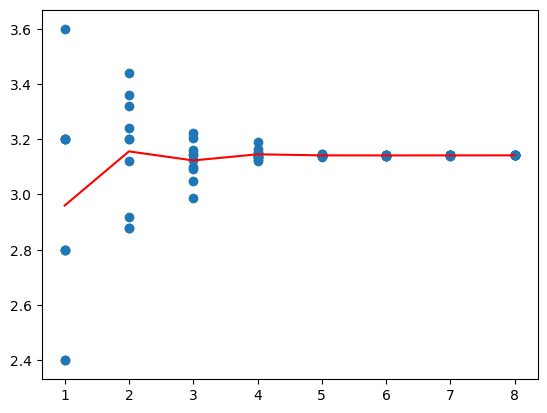

In [27]:
nsamples_set = [10,100,1000,10000,100000,1000000,10000000,100000000] # What values of nsamples to use
n_for_each_nsamples = 10 # How many times to calculate pi for each nsamples value
n_values = np.zeros(0) # Initialise empty Numpy array
pi_estimate_set = np.zeros(0) # Initialise empty Numpy array
pi_estimate_means = np.zeros(0)
for i in nsamples_set:
    this_pi_mean = 0 # Add up the j values of pi for each nsamples value
    for j in range(n_for_each_nsamples):
        n_values  = np.append(n_values,i)
        this_pi_estimate = monte_carlo_pi(i)
        pi_estimate_set = np.append(pi_estimate_set,this_pi_estimate)
        this_pi_mean = this_pi_mean + this_pi_estimate
    this_pi_mean = this_pi_mean/n_for_each_nsamples # Calculate mean value of pi for this i
    pi_estimate_means = np.append(pi_estimate_means,this_pi_mean)
plt.scatter(np.log10(n_values),pi_estimate_set) # Plot the individual pi estimates
plt.plot(np.log10(nsamples_set),pi_estimate_means,color='red') # Plot the means

We can now reasonable quickly generate a billion samples and use it to estimate $\pi$:

In [30]:
monte_carlo_pi(1000000000)

3.141598456